# Wildlife Trajectories in R
Adam Mahood

In [58]:
library(rgl) # this is the 3d plotting package I used
library(wildlifeDI) # Jed's package
library(plyr) # have to use plyr::join because adehabitatMA masks join and ID
library(adehabitatLT) # also required for everything in Jed's package, 
#                     but does not automatically install or load with 
#                     the library command.
#                     it is used to create the trajectory objects

library(gplots) # for the sweet heatmap function


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



## Data Wrangling!!!
There is significant wrangling, to get the dates (and more! see comments inline) right for both the plot3d function and the wildlifeDI trajectory files

In [3]:
#setwd('~/DATA/BEARS') #have to change this to 
##                    mesh with the github directory structure
bears = read.csv('Data/CopyOfBrown_bear_Slovenia_1993-1999.csv')

#making a number for each bear (plot3d doesn't like characters as far as i can tell)

levels = as.data.frame(levels(bears$individual.local.identifier))
levels$bear_number = c(1:22)
bears$tag = bears$individual.local.identifier
levels$tag = levels$`levels(bears$individual.local.identifier)`
bears = plyr::join(bears, levels, by = "tag")
bears$date = paste(substr(bears$timestamp, 1,4),substr(bears$timestamp,6,7),substr(bears$timestamp,9,10),sep="")
bears$date = as.Date(bears$date, "%Y%m%d")
bears$da = as.POSIXct(strptime(as.character(bears$date), "%Y-%m-%d"))

# stuff's not working for creating trajectory objects, hence (from google)

# sum(duplicated(paste(bears$da, bears$individual.local.identifier)))
# duplicated(paste(bears$da, bears$individual.local.identifier))

# the first line identifies how many duplicates there are, second line 
# helps you manually figure out which one is which, so we can get rid 
# of those rows

bears = bears[-692,]
bears = bears[-1715,]
bears = bears[-154,]
#and then another duplicate magically creates itself
bears = bears[-1713,]

## Plotting 3d

This is bit of an unstable package so far. I haven't found the way to make the plot pop up inside the web page, rather than in a pop up window. Looks cool though! In my system, this script created a pop-up window with an interactive 3d plot that worked when I ran it out of R Studio, but out of the notebook the popup window wasn't working right. not sure what the deal is there. There is another function in the rgl package called WebGL, which embeds the 3d plot in the html, but I could quite figure it out. 

I found it difficult to get 22 colors that looked distinct. I suspect the solution lies with RColorBrewer.

I first created a 3d plot of the points, and then loop through and create a line for each bear.

In [3]:
cols = colors() #vector of all colors
set.seed(1223)
bear_colors = cols[as.integer(runif(22,1,657))]

plot3d(bears$utm.easting, bears$utm.northing, bears$date, col= bear_colors[bears$bear_number])

for(i in 1:22){
  bear_n = bears[bears$bear_number == i,]
  x = bear_n$utm.easting
  y = bear_n$utm.northing
  z = bear_n$date
  lines3d(x,y,z,col=bear_colors[i])
}

## WildlifeDI
I had some troubles with this. The data formats are really fussy, and for all the really cool tests, I got a lot of mysterious errors that Duck Duck Go had no solution for. However, Duck Duck Go did help me at least get the temporal overlap for all 22 bears against each other.

#### We start by creating trajectory files for each bear

In [4]:
for(i in 1:22){

  bear_n = bears[bears$bear_number == i,]
  xy = bear_n[,14:15]
  da = bear_n$da
  id = as.factor(bear_n$bear_number)
  
  tr1 <- as.ltraj(xy,
                 date = da,
                 id=id)
  nam = paste("tr", i, sep = "_")
  assign(nam, tr1)

}


### The CheckTO function

This function outputs a list of 3 items:
1. True or False: is there temporal overlap?
2. When the overlap starts
3. When the overlap ends

I constructed two loops; first for the occurence of overlap, and the second for the duration of overlap (in days)

In [19]:
# put trajectories into lists
TR_list = list(tr_1,tr_2, tr_3,tr_4, tr_5,tr_6,tr_7,tr_8,tr_9,tr_10, tr_11, tr_12,tr_13, tr_14, tr_15, tr_16, tr_17,tr_18,tr_19,tr_20,tr_21,tr_22)
TR_list1 = TR_list


results_checkTO = as.data.frame(matrix(nrow = 22, ncol = 22))
for(i in 1:22){
  for(j in 1:22){
    
  a = TR_list[[i]]
  b = TR_list1[[j]]
  results_checkTO[i,j]=ifelse(i==j, NA, wildlifeDI::checkTO(a,b))
  }}

results_checkTO_duration = as.data.frame(matrix(nrow = 22, ncol = 22))
for(i in 1:22){
  for(j in 1:22){
    
  a = TR_list[[i]]
  b = TR_list1[[j]]
  results_checkTO_duration[i,j]=ifelse(i==j, NA, checkTO(a,b)[[3]]-checkTO(a,b)[[2]])
  }}


## Visualizing the temporal overlap

I used a heatmap to visualize the temporal overlap of each possible bear combination. Ancka was there throughout the study, and overlapped with every other bear. 

The heatmap function requires a numeric matrix. It uses a clustering algorithm to reorder the rows and columns into similar groups. The first heatmap shows there are three cluster of bears that are present in the study at different times, and those three groups don't really overlap very much. The second heatmap shows that there are a handful of bears with a long duration of temporal overlap, while most have a relatively short temporal overlap.

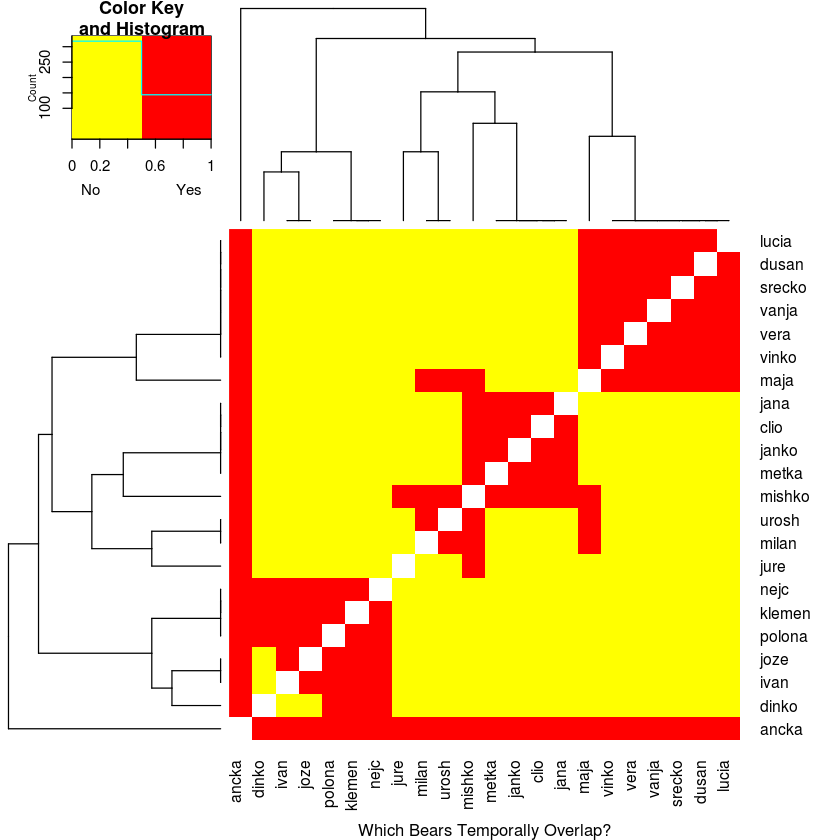

In [79]:
RM = data.matrix(results_checkTO)
rownames(RM) = levels$tag
colnames(RM) = levels$tag
heatmap.2(RM,
             sub = "Which Bears Temporally Overlap?",
             col = c("yellow", "red"),
             key.xlab = "No                   Yes",
             trace='none'
         )



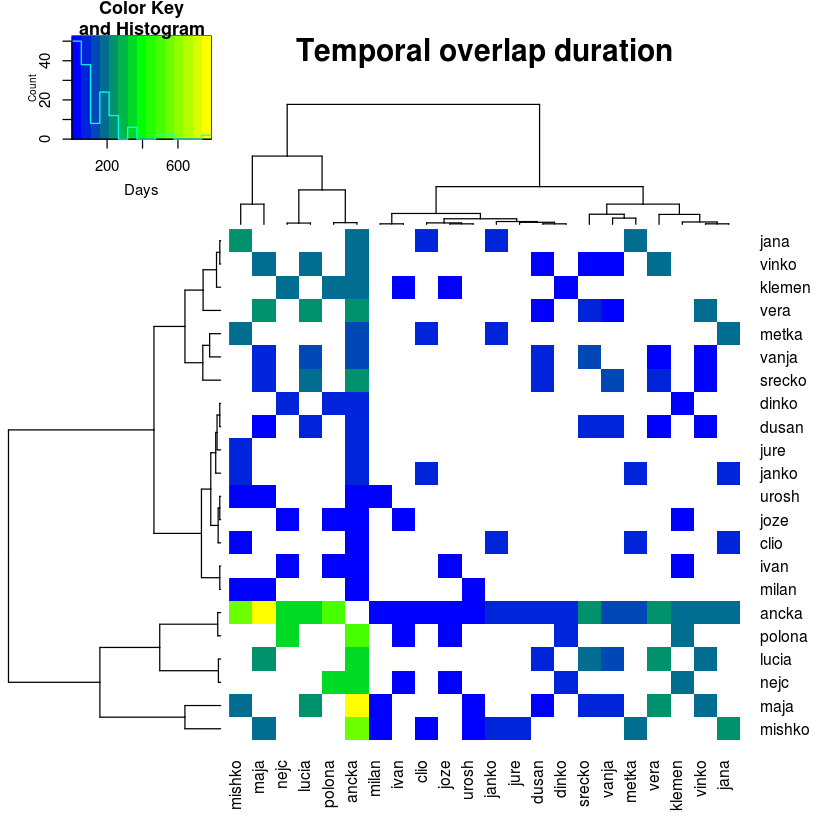

In [89]:
RDM = data.matrix(results_checkTO_duration)
rownames(RDM) = levels$tag
colnames(RDM) = levels$tag
heatmap.2(RDM,  
          scale = "none",
          main = "Temporal overlap duration", 
          key.xlab="Days",
          trace = "none",
          col = colorRampPalette(c("blue", "green", "yellow"))
         )

